<a href="https://colab.research.google.com/github/Rok-sana/ML-course/blob/main/Homework_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)

from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             roc_auc_score, 
                             f1_score)

from sklearn import preprocessing

from sklearn.preprocessing import(MinMaxScaler,
                                  StandardScaler,
                                  LabelEncoder)

from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D

from imblearn.over_sampling import SMOTE

In [ ]:
glass_df = pd.read_csv('glass.data', header=None)
glass_df = glass_df.drop(glass_df.columns[0], axis=1)
glass_df.columns = ['r_index', 'sodium', 'magnesium', 'aluminum', 'silicon', 'potassium', 'calcium', 'barium', 'iron', 'glass_type']

In [ ]:
glass_df.head()

,r_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron,glass_type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [ ]:
glass_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   r_index     214 non-null    float64
 1   sodium      214 non-null    float64
 2   magnesium   214 non-null    float64
 3   aluminum    214 non-null    float64
 4   silicon     214 non-null    float64
 5   potassium   214 non-null    float64
 6   calcium     214 non-null    float64
 7   barium      214 non-null    float64
 8   iron        214 non-null    float64
 9   glass_type  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [ ]:
glass_df['glass_type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: glass_type, dtype: int64

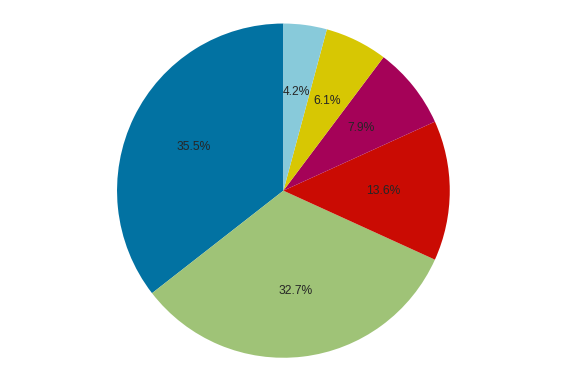

In [ ]:
plt.pie(
    glass_df['glass_type'].value_counts(),
    shadow = False,
    startangle=90,
    autopct='%1.1f%%'
)
plt.axis('equal')
plt.tight_layout()
plt.show()

Target is categorized not equivalent

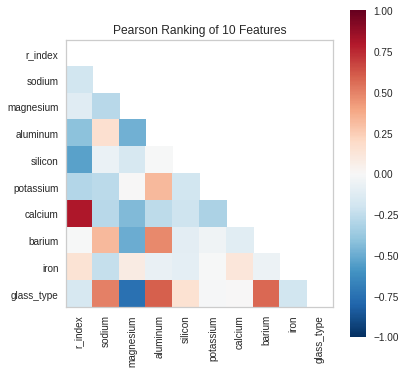

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
pcv = Rank2D(features=glass_df.columns, algorithm="pearson")
pcv.fit(glass_df, glass_df.glass_type)
pcv.transform(glass_df)
pcv.poof()

In [ ]:
def correlated_columns(df, threshold=0.95):
  return (df.corr().pipe(
      lambda df1: pd.DataFrame(
            np.tril(df1, k=-1),
            columns=df.columns,
            index=df.columns,))
  .stack()
  .rename("pearson")
  .pipe(
      lambda s: s[s.abs() > threshold].reset_index())
  .query("level_0 not in level_1"))

In [ ]:
c_df = correlated_columns(glass_df)
c_df.style.format({"pearson": "{:.2f}"})

,level_0,level_1,pearson


In this case data haven't over correlated values 

In [ ]:
y = glass_df.glass_type
X = glass_df.drop(glass_df.columns[9], axis=1)

In [ ]:
y = LabelEncoder().fit_transform(y)

In [ ]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In this dataset for avoiding the imbalanced-learn implements  SMOTE, which both upsample and then apply downsampling to clean up the data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y,random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
     

((342, 9), (114, 9), (342,), (114,))

In [ ]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
model_name = []
test_score = []
train_score= []

**1. DecisionTreeClassifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

# storing training data accuracy
train_score.append(tree.score(X_train, y_train))      
model_name.append('DecisionTree')

# storing test data accuracy
y_pred_tree = tree.predict(X_test)
test_score.append(f1_score(y_test, y_pred_tree, average='micro'))

**2.RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_grid = {'n_estimators': [50,100,200, 400],
               'max_depth': [10, 20, 30, 40, 50], 
               'criterion': ["entropy", "gini"]
               }

clf_grid = GridSearchCV(RandomForestClassifier(random_state=0), random_grid, verbose=1, cv=4, scoring='f1_micro')
                
# Train the classifier
clf_grid.fit(X_train, y_train)

print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 4 folds for each of 40 candidates, totalling 160 fits
Best Parameters:
 {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 400}
Best Estimators:
 RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=400,
                       random_state=0)


In [ ]:
rfc = RandomForestClassifier(max_depth=20,n_estimators=400,criterion='entropy',random_state=0)
rfc.fit(X_train, y_train)

# storing training data accuracy
train_score.append(rfc.score(X_train, y_train))
model_name.append('RandomForest')

# storing test data accuracy
y_pred_rand = rfc.predict(X_test)
test_score.append(f1_score(y_test, y_pred_rand, average='micro'))

**3.SVC**

In [ ]:
from sklearn.svm import SVC 

param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
# Make grid search classifier
clf_grid = GridSearchCV(SVC(), param_grid, verbose=1, scoring='f1_micro')
                
# Train the classifier
clf_grid.fit(X_train, y_train)

print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Parameters:
 {'C': 1000, 'gamma': 0.1}
Best Estimators:
 SVC(C=1000, gamma=0.1)


In [ ]:
model = SVC(C = 1000, gamma= 0.1)

model.fit(X_train,y_train)
# storing test data accuracy
train_score.append(model.score(X_train, y_train))
model_name.append('SVC')

# storing test data accuracy
y_pred_svc = model.predict(X_test)
test_score.append(f1_score(y_test, y_pred_svc, average='micro'))

**4.AdaBoostClassifier**

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(base_estimator=rfc, n_estimators=50, learning_rate=1)
adaboost.fit(X_train, y_train)

# storing training data accuracy
train_score.append(adaboost.score(X_train, y_train))
model_name.append('AdaBoost')

# storing test data accuracy
y_pred_ada = adaboost.predict(X_test)
test_score.append(f1_score(y_test, y_pred_ada, average='micro'))
     

**5.XGBClassifier**

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

train_score.append(xgb.score(X_train, y_train))
model_name.append('XGBoost')

y_pred_xgb = xgb.predict(X_test)
test_score.append(f1_score(y_test, y_pred_xgb, average='micro'))


In [ ]:
result = pd.DataFrame()
result['model'] = pd.Series(model_name)
result['Train score'] = pd.Series(train_score).round(2)
result['Test score'] = pd.Series(test_score).round(2)

In [ ]:
result

,model,Train score,Test score
0,DecisionTree,1.00,0.89
1,RandomForest,1.00,0.93
2,SVC,0.99,0.90
3,AdaBoost,1.00,0.93
4,XGBoost,1.00,0.94


Best results on test dataset shows RandomForest classifier, AdaBoost and XGBoost. F1 scores are equal 93% and 94%